<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/mlps/AK_MM_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will do the following things:

We are creating a neural network that takes 3 characters (with an embedding dimension of 10) and predicts the 4th with names.txt as dataset

*   Create a train/test/dev dataset from names.txt
*   Create a neural net with the following architecture
  * 2 Layers (n_hidden=200), Tanh as non-linearity
  * add custom batchnormalisation and weight initialisation techniques
  * Plot the Tanh saturation (with and without the above techniques)
* Create a neural net with from separate layer modules
  * 6 Linear layers (n_hidden=200), Tanh as non-linearity (without and with batchnorm)
  * add the following histogram plots
    * forward pass activations (layer.out)
    * backward pass activations (layer.out.grad)
    * parameter.grad (and parameter.grad /parameter.data ratio)
    * parameter update/parameter.data ratio

    
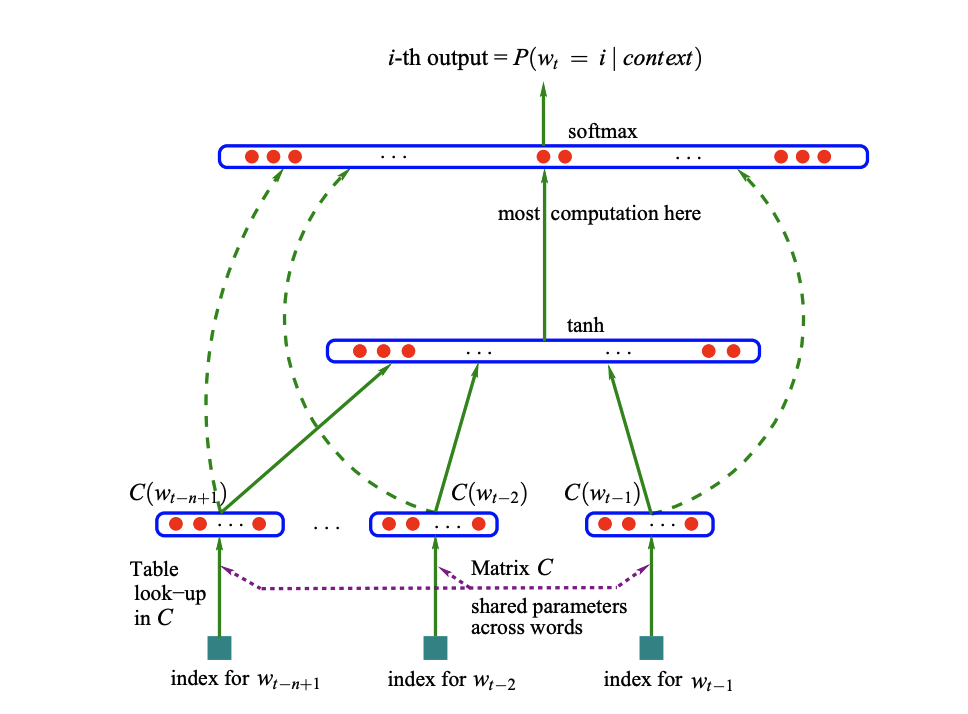






In [45]:
import torch
import torch.nn.functional as F

In [46]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
words = open("/content/drive/MyDrive/Data/AK/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [48]:
# ITOS and STOI
chars = sorted(list(set("".join([word for word in words]))))
itos = {i+1 : char for i,char in enumerate(chars)}
itos[0] = "."
stoi = {char : i for i, char in itos.items()}
vocab_size = len(itos)

In [49]:
# BUILDING THE DATASET
block_size = 3

x = []
y = []

for word in words:

  context = [0] * block_size
  for char in word + ".":
    x.append(context)
    ix = stoi[char]
    context = context[1:] + [ix]
    y.append(ix)

X = torch.tensor(x)
Y = torch.tensor(y)

import random
seed = 42
random.Random(seed).shuffle(X)
random.Random(seed).shuffle(Y)
dev_index = int(0.8 * len(X))
test_index = int(0.9 * len(X))

Xdev = X[dev_index:test_index]
Ydev = Y[dev_index:test_index]

Xtest = X[test_index:]
Ytest = Y[test_index:]

Xtr = X[:dev_index]
Ytr = Y[:dev_index]

In [50]:
Xdev.shape, Xtest.shape, Xtr.shape

(torch.Size([22815, 3]), torch.Size([22815, 3]), torch.Size([182516, 3]))

In [51]:
Ydev.shape, Ytest.shape, Ytr.shape

(torch.Size([22815]), torch.Size([22815]), torch.Size([182516]))

In [69]:
# Create MLP
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((30, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
bngain = torch.ones(1,n_hidden)
bnbias = torch.zeros(1, n_hidden)
bn_running_mean = torch.zeros((1, n_hidden))
bn_running_std = torch.ones((1, n_hidden))

parameters = [W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [70]:
n_epochs = 1
batch_size = 32
learning_rate = 0.001

for it in range(n_epochs):
  # take a batch
  idx = torch.randint(0, Xtr.shape[0], (32,))
  X_b = Xtr[idx]
  Y_b = Ytr[idx]
  emb = C[X_b]
  hpreact = emb.view(32,-1) @ W1 + b1

  bmeani = hpreact.mean(0, keepdim=True)
  bstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bmeani) / bstdi + bnbias

  with torch.no_grad():
    bn_running_mean = 0.999 * bn_running_mean + 0.001 * bmeani
    bn_running_std = 0.999 * bn_running_std + 0.001 * bstdi

  hreact = torch.tanh(hpreact)
  logits = hreact @ W2 + b2
  loss = F.cross_entropy(logits, Y_b)
  optimizer = torch.optim.Adam(params=parameters, lr=learning_rate)

  # zero grad optimizer
  for p in parameters:
    p.grad = None

  loss.backward()

  # step optimizer
  for p in parameters:
    p.data += -learning_rate * p.grad

  optimizer.step()

  print(loss.item())




16.18049430847168


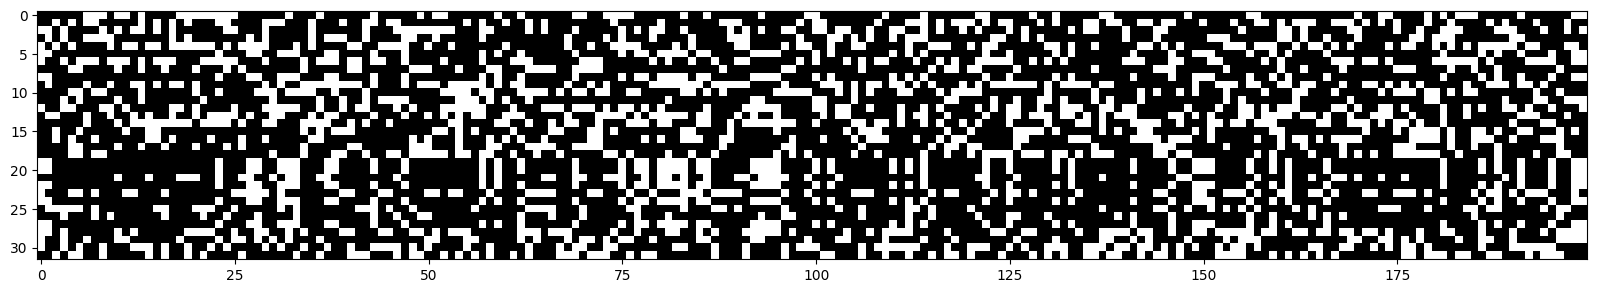

In [71]:
# Plot tanh saturation
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(hpreact.abs() > 0.99, cmap="gray", interpolation="nearest")

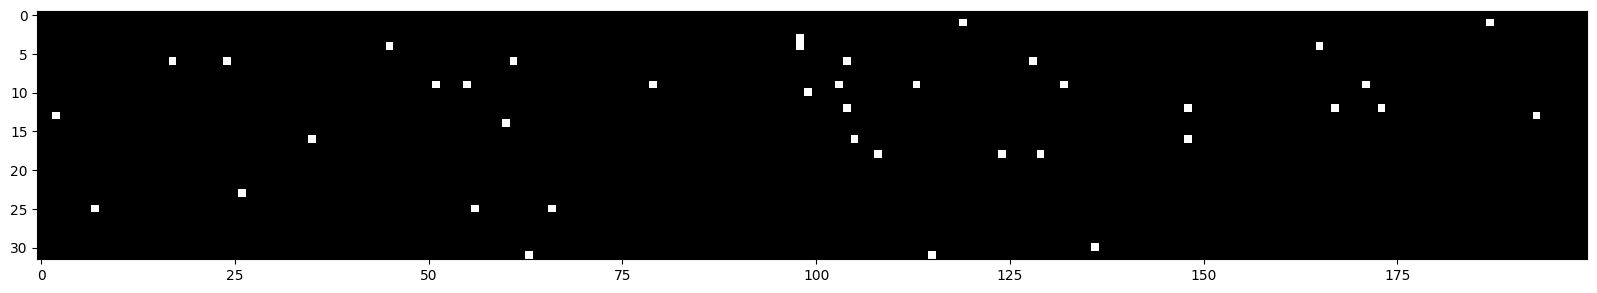

In [72]:
plt.figure(figsize=(20,10))
plt.imshow(hreact.abs() > 0.99, cmap="gray", interpolation="nearest")

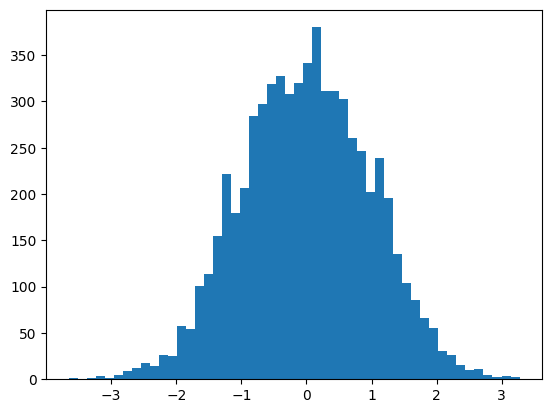

In [77]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

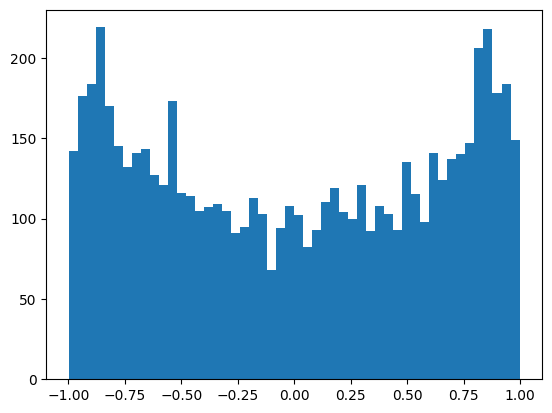

In [79]:
plt.hist(hreact.view(-1).tolist(), bins=50);

In [66]:
hreact.view(-1).shape

torch.Size([6400])

In [43]:
hpreact.shape

torch.Size([32, 200])

In [39]:
hpreact.mean(0).shape

torch.Size([200])

In [40]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

tensor([144244, 154518,  81072, 172471, 156402,  76269,  31712, 110143,  37534,
         61944,  72615, 160968, 143207,  41954,  41992, 111771,  87190,   1199,
         89682, 173261, 144429,  79027, 112941, 129585,  68383, 161069,  76936,
         80564, 156893, 127354, 158349,  41897])

In [ ]:
t = torch.randint(0, Xtr.shape[0], (32,))

In [ ]:
Xtr[t]

tensor([[ 1, 25, 19],
        [ 0,  0, 11],
        [12, 12,  9],
        [21,  9, 12],
        [26,  1, 25],
        [ 1,  2, 18],
        [ 1, 18, 11],
        [ 0,  8,  1],
        [ 9, 14,  1],
        [18,  5, 12],
        [15, 18,  1],
        [ 0,  0,  0],
        [12,  9,  1],
        [ 0,  0,  0],
        [ 5, 13,  1],
        [ 0,  0,  0],
        [ 9,  5, 12],
        [ 0, 13,  1],
        [ 0,  4,  5],
        [ 1, 20,  8],
        [ 0,  9,  4],
        [13,  9, 12],
        [ 9, 12,  1],
        [18,  5, 19],
        [ 0, 11, 25],
        [18, 15,  3],
        [ 1, 14,  1],
        [ 0,  0,  0],
        [14,  1,  6],
        [ 0,  1, 22],
        [ 8, 15,  4],
        [ 0,  1, 14]])

In [ ]:
Ytr[t]

tensor([19, 15,  5,  1, 12,  9,  1, 25,  0, 25,  9, 11,  0, 19,  5, 10, 25,  9,
        10,  5, 25,  1, 14, 12,  1,  8,  0, 11,  9,  9,  1, 14])

In [ ]:
C[Xtr[t]].shape

torch.Size([32, 3, 10])